Nathan Deinlein <br>
Ryan Kinney <br>
Chris Roche <br>
Cameron Stewart <br>

# Machine Learning 1 - Lab 2 Classification

## Section 1: Data Preparation

Talk about data prep here.

[10 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from sklearn.metrics import plot_confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

In [2]:
# read in the data
url = "https://raw.githubusercontent.com/nedeinlein/Machine_Learning_I/main/runs_clean.csv"
runs_df = pd.read_csv(url, index_col=False)

runs_df.head()

,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec2,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,2.00,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,9.00,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,1.00,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,5.00,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,8.75,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154


In [3]:
# Use one hot encoding on non-numerical features
## (Then remove them from the drop code chunk below)
# perform one-hot encoding of the categorical data "embarked"
tmp_df = pd.get_dummies(runs_df.horse_country,prefix='horse_country')
runs_df_onehot = pd.concat((runs_df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(runs_df.horse_type,prefix='horse_type')
runs_df_onehot = pd.concat((runs_df_onehot,tmp_df),axis=1) # add back into the dataframe

[5 points] Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). 

## Section 2: Modeling and Evaluation

Intro paragraph for section 2 here...

[10 points] Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.

Our primary metric for evaluating model performance is Area Under the Curve (AUC). AUC score provides a good balance between accuracy, specificity, and sensitivity. In an unbalanced data set such as this one, you cannot rely on accuracy alone. 

Since 92% of the observations in the data set are losers, creating a "model" that predicts a loss for every observation would have an accuracy of 92% but offer no practical use.

[10 points] Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate.

For dividing our test and train data sets we used 10-fold Stratified Cross Validation (CV). In 10-fold CV, the data set is divided into 10 groups where one becomes the hold out (test) set and the other 9 become the training data. In Stratified CV, the proportion of observations is preserved in each fold. There are many more losers than winners in this data set. Therefore, preserving the proportion of winners to losers in each fold is important to ensure you do not accidentally create a test set of all losers.

In [4]:
runs_df = runs_df.reset_index(drop=True)
runs_data = runs_df.drop(['Unnamed: 0','race_id','horse_id','result','won','lengths_behind','horse_country','horse_type','horse_gear','position_sec1','position_sec2','position_sec3','behind_sec1','behind_sec2','behind_sec3','time1','time2','time3','finish_time','trainer_id','jockey_id'], axis=1)
runs_target = runs_df['won']
runs_data.head()

,horse_no,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds
0,1,3,60,1020.0,133,7,9.7,3.7
1,2,3,60,980.0,133,12,16.0,4.9
2,3,3,60,1082.0,132,8,3.5,1.5
3,4,3,60,1118.0,127,13,39.0,11.0
4,5,3,60,972.0,131,14,50.0,14.0


In [5]:
cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

# fill in the training and testing data and save as separate variables
for trainidx, testidx in cv.split(runs_data,runs_target):
    # note that these are sparse matrices
    X_train,X_test = runs_data.iloc[trainidx], runs_data.iloc[testidx] 
    Y_train, Y_test = runs_target.iloc[trainidx], runs_target.iloc[testidx]

### Scaling data

In [6]:
scl_obj = StandardScaler()
X_train = scl_obj.fit_transform(X_train, y = None)
X_test = scl_obj.fit_transform(X_test, y = None)

### Section 2.1: Model 1 - K-Nearest Neighbors

K-Nearest Neighbors is an algorithm frequently used for classification. In order to classify an observation, the algorithm measures the distance from the given observation to it's K nearest neighbors, where K is a tunable parameter.

For each iteration of the model fitting, we try a different K value and print out the model accuracy and AUC score. Because the data set is not balanced, we use AUC as the primary metric for comparing model performance. If we only used accuracy, we could achieve an accuracy of over 90% simply by classifying every observation as a "los", but this has no practical use.

First, we implemented two models. Both use Euclidean distance but one uses a uniform weight and the other uses distance. For uniform weight, all the nearest neighbors have the same impact in classification. In distance, closer neighbors have more impact.

The difference in model performance for uniform vs. distance was negligable, but the model with weights='distance' trained more quickly so we elected to use that parameter.

#### Euclidean Distance, Uniform Weights

In [7]:
# Use Euclidean distance and iterate over several K-values
## ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.
Kvals = [3,5,7,9,11,13,15,17,19,21]
for x in Kvals:
    clf_knn = KNeighborsClassifier(n_neighbors=x, weights='uniform', metric='euclidean')
    clf_knn.fit(X_train,Y_train)
    yhat= clf_knn.predict(X_test)
    acc = mt.accuracy_score(Y_test,yhat)
    auc = roc_auc_score(Y_test,yhat)
    conf = mt.confusion_matrix(Y_test,yhat)
    print('Accuracy of classifier with %d neighbors is: %.3f'%(x,acc), ' AUC: %.3f'%auc)

Accuracy of classifier with 3 neighbors is: 0.900  AUC: 0.513
Accuracy of classifier with 5 neighbors is: 0.913  AUC: 0.508
Accuracy of classifier with 7 neighbors is: 0.917  AUC: 0.504
Accuracy of classifier with 9 neighbors is: 0.918  AUC: 0.501
Accuracy of classifier with 11 neighbors is: 0.920  AUC: 0.501
Accuracy of classifier with 13 neighbors is: 0.920  AUC: 0.501
Accuracy of classifier with 15 neighbors is: 0.920  AUC: 0.501
Accuracy of classifier with 17 neighbors is: 0.920  AUC: 0.500
Accuracy of classifier with 19 neighbors is: 0.920  AUC: 0.500
Accuracy of classifier with 21 neighbors is: 0.920  AUC: 0.500


#### Euclidean Distance, Distance Weights

In [8]:
# Use Euclidean distance - sqrt(sum((x - y)^2))
## ‘distance’ : weight points by the inverse of their distance. 
##    in this case, closer neighbors of a query point will have a greater 
##    influence than neighbors which are further away.

Kvals = [3,5,7,9,11,13,15,17,19,21]
for x in Kvals:
    clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='euclidean')
    clf_knn.fit(X_train,Y_train)
    yhat= clf_knn.predict(X_test)
    acc = mt.accuracy_score(Y_test,yhat)
    auc = roc_auc_score(Y_test,yhat)
    conf = mt.confusion_matrix(Y_test,yhat)
    print('Accuracy of classifier with %d neighbors is: %.3f'%(x,acc), ' AUC: %.3f'%auc)
    
# Note: weights='distance' runs quicker and produces the same accuracy results

Accuracy of classifier with 3 neighbors is: 0.897  AUC: 0.517
Accuracy of classifier with 5 neighbors is: 0.910  AUC: 0.511
Accuracy of classifier with 7 neighbors is: 0.915  AUC: 0.508
Accuracy of classifier with 9 neighbors is: 0.917  AUC: 0.504
Accuracy of classifier with 11 neighbors is: 0.918  AUC: 0.504
Accuracy of classifier with 13 neighbors is: 0.919  AUC: 0.502
Accuracy of classifier with 15 neighbors is: 0.919  AUC: 0.501
Accuracy of classifier with 17 neighbors is: 0.920  AUC: 0.501
Accuracy of classifier with 19 neighbors is: 0.920  AUC: 0.501
Accuracy of classifier with 21 neighbors is: 0.920  AUC: 0.501


The next parameter we experimented with was the weight metric. We re-ran the model several times using different metrics from the sklearn DistanceMetric library, to include Manhatten and Chebyshev.

Again, the model performance for the different metrics was negligable so we elected to use Euclidean distance since it is well optimized for large data sets.

#### Manhatten Distance

In [9]:
# Use Manhatten distance - sum(|x - y|)

Kvals = [3,5,7,9,11,13,15,17,19,21]
for x in Kvals:
    clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='manhattan')
    clf_knn.fit(X_train,Y_train)
    yhat= clf_knn.predict(X_test)
    acc = mt.accuracy_score(Y_test,yhat)
    auc = roc_auc_score(Y_test,yhat)
    conf = mt.confusion_matrix(Y_test,yhat)
    print('Accuracy of classifier with %d neighbors is: %.3f'%(x,acc), ' AUC: %.3f'%auc)

Accuracy of classifier with 3 neighbors is: 0.898  AUC: 0.520
Accuracy of classifier with 5 neighbors is: 0.909  AUC: 0.514
Accuracy of classifier with 7 neighbors is: 0.915  AUC: 0.511
Accuracy of classifier with 9 neighbors is: 0.917  AUC: 0.509
Accuracy of classifier with 11 neighbors is: 0.919  AUC: 0.505
Accuracy of classifier with 13 neighbors is: 0.920  AUC: 0.503
Accuracy of classifier with 15 neighbors is: 0.920  AUC: 0.501
Accuracy of classifier with 17 neighbors is: 0.920  AUC: 0.501
Accuracy of classifier with 19 neighbors is: 0.920  AUC: 0.501
Accuracy of classifier with 21 neighbors is: 0.920  AUC: 0.501


#### Chebyshev Distance

In [10]:
# Use ChebyshevDistance distance - max(|x - y|)

Kvals = [3,5,7,9,11,13,15,17,19,21]
for x in Kvals:
    clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='chebyshev')
    clf_knn.fit(X_train,Y_train)
    yhat= clf_knn.predict(X_test)
    acc = mt.accuracy_score(Y_test,yhat)
    auc = roc_auc_score(Y_test,yhat)
    conf = mt.confusion_matrix(Y_test,yhat)
    print('Accuracy of classifier with %d neighbors is: %.3f'%(x,acc), ' AUC: %.3f'%auc)

Accuracy of classifier with 3 neighbors is: 0.899  AUC: 0.516
Accuracy of classifier with 5 neighbors is: 0.910  AUC: 0.507
Accuracy of classifier with 7 neighbors is: 0.915  AUC: 0.506
Accuracy of classifier with 9 neighbors is: 0.917  AUC: 0.503
Accuracy of classifier with 11 neighbors is: 0.919  AUC: 0.503
Accuracy of classifier with 13 neighbors is: 0.919  AUC: 0.501
Accuracy of classifier with 15 neighbors is: 0.920  AUC: 0.501
Accuracy of classifier with 17 neighbors is: 0.920  AUC: 0.501
Accuracy of classifier with 19 neighbors is: 0.920  AUC: 0.501
Accuracy of classifier with 21 neighbors is: 0.920  AUC: 0.501


With each of the KNN models above, the accuracy and AUC tend to stabilize at around k=11. Note as the K value increases so too does the accuracy but the AUC decreases. Choosing a smaller K-value such as 7 produces a goo balace between the different metrics.

We fit a final KNN using the parameters selected: Euclidean, Distance weights for neighbors, and 7 neighbors.

#### KNN with Euclidean, Distance weight, and K=7 neighbors

In [11]:
# Based on above, Euclidean with K=7 is a good combination of accuracy and AUC
x=7
clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='euclidean')
clf_knn.fit(X_train,Y_train)
yhat= clf_knn.predict(X_test)
acc = mt.accuracy_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
conf = mt.confusion_matrix(Y_test,yhat)

Below is the Confusion Matrix plotted for the model. As can be seen, it classified the majority of observations as loses (correctly). This makes sense since about 92% of the data set are horses who did not win their race.

#### Confusion Matrix for KNN Model

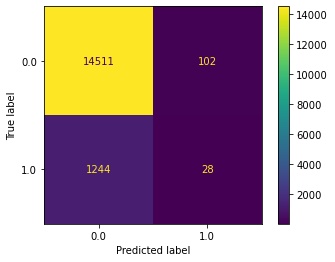

In [12]:
plot_confusion_matrix(clf_knn, X_test, Y_test)

In [13]:
# I tried several different algorithm parameters here (e.g. kd_tree, ball_tree) without effect
x=7
clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='euclidean', algorithm='kd_tree')
clf_knn.fit(X_train,Y_train)
yhat= clf_knn.predict(X_test)
acc = mt.accuracy_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
conf = mt.confusion_matrix(Y_test,yhat)
print('Accuracy of classifier with %d neighbors is: %.3f'%(x,acc), ' AUC: %.3f'%auc)

Accuracy of classifier with 7 neighbors is: 0.915  AUC: 0.508


From the Confusion Matrix above, notice the large number of false positives. The model incorrectly classified over 1000 observations as wins when they should have been loses. It only correctly classified about 50 wins. Since this data set is results of horse races, you can assume an interested party would be a gambler. The KNN model would not be of much benefit to a gambler due to the large number of Type I error in proportion to true positive results.

### Section 2.2: Model 2 - Random Forest

Implement model here, including accuracy, AUC score, and Confusion Matrix.

### Section 2.3: Model 3 - Support Vector Machines

Implement model here, including accuracy, AUC score, and Confusion Matrix.

### Section 2.4: Model 4

Implement model here, including accuracy, AUC score, and Confusion Matrix.

### Section 2.5: Model Comparison and Feature Importance

[10 points] Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods.

[10 points] Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

## Section 3: Deployment

[5 points] How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? 

## Section 4: Summary

Summarize the Lab here.